In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
import numpy as np
import multiprocessing
from math import sin, cos, sqrt, pi
import cv2
from PIL import Image
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

In [ ]:
!unzip train2017.zip

In [ ]:
class CocoDetection(torch.utils.data.Dataset):

    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        self.files = [f for f in os.listdir(self.root) if os.path.isfile(os.path.join(self.root, f))]


    def __getitem__(self, index):

        path = os.path.join(self.root, self.files[index])

        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        return img


    def __len__(self):
        return len(self.files)

## Define Model

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, c):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(c, c, 3, 1)
        self.bn1 = nn.BatchNorm2d(c)

        self.conv2 = nn.Conv2d(c, c, 3, 1)
        self.bn2 = nn.BatchNorm2d(c)
        
        self.activation = nn.ReLU(True)

    def forward(self, x):
        identity = x

        x = self.bn1(self.conv1(x))
        x = self.activation(x)

        x = self.bn2(self.conv2(x))
        return x + transforms.CenterCrop(x.shape[-2:])(identity)


class StyleTransfer(nn.Module):
    def __init__(self):
        super(StyleTransfer, self).__init__()

        self.padding = nn.ReflectionPad2d(40)

        conv_package = lambda in_c, out_c, kernel, s : [nn.Conv2d(in_c, out_c, kernel, s, (kernel - 1) // 2), nn.BatchNorm2d(out_c), nn.ReLU(True)]
        deconv_package = lambda in_c, out_c, kernel, s : [nn.ConvTranspose2d(in_c, out_c, kernel, s, padding=1, output_padding=1), nn.BatchNorm2d(out_c), nn.ReLU(True)]
        
        
        self.conv_block = nn.Sequential(  *(conv_package(3, 32, 9, 1) + conv_package(32, 64, 3, 2) + conv_package(64, 128, 3, 2)) )

        self.res_blocks = nn.Sequential( *[ResidualBlock(128) for _ in range(5)] )

        self.deconv_block = nn.Sequential( *(deconv_package(128, 64, 3, 2) + deconv_package(64, 32, 3, 2)) )

        self.output_layer = nn.Conv2d(32, 3, 9, 1, 'same')
    
    def forward(self, x):
        x = self.padding(x)

        x = self.conv_block(x)
        x = self.res_blocks(x)
        x = self.deconv_block(x)
        out = self.output_layer(x)
        return (torch.tanh(out) + 1) / 2 # normalize output to [0, 1]

In [ ]:
class PerceptualLoss():
    def __init__(self, device):
        super(PerceptualLoss, self).__init__()

        vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True).eval()
        self.vgg16  = vgg16.features.to(device) # Just extract the fully convolutional model

        # placeholder for batch features
        self.features = {}

        # Helper function for feature extraction
        def get_features(name):
            def hook(model, input, output):
                self.features[name] = output
            return hook

        # Register Hook
        self.layers = [('relu1_2', 3), ('relu2_2', 8), ('relu3_3', 15), ('relu4_3', 22)]
        for layer_name, layer_index in self.layers:
            self.vgg16[layer_index].register_forward_hook(get_features(layer_name))

        '''
        # forward pass [with feature extraction]
        preds = vgg16(torch.rand((1,3,256,256)))

        for layer_name, _ in layers:
            print(features[layer_name].shape)
        '''

    def feature_reconstruction_loss(self, x1, x2):
        x = torch.concat((x1, x2), dim=0)
        self.vgg16(x)
        feature_maps = self.features['relu3_3']

        N = x1.shape[0]
        C, H, W = feature_maps.shape[1:]
        feature_map_x1 = feature_maps[:N]
        feature_map_x2 = feature_maps[N:]
        return F.mse_loss(feature_map_x1, feature_map_x2) # mse_loss already normalizes / (C*H*W)

    def  style_reconstruction_loss(self, x1, x2):
        x = torch.concat((x1, x2), dim=0) # x1 and x2 HxW must be equivalent
        self.vgg16(x)
        N = x1.shape[0]
        

        loss = 0
        for layer_name, _ in self.layers:
            feature_maps = self.features[layer_name]
            C, H, W = feature_maps.shape[1:]
            
            feature_map_x1 = feature_maps[:N].reshape((N, C, -1))
            feature_map_x2 = feature_maps[N:].reshape((N, C, -1))

            gram_mat_x1 = feature_map_x1 @ torch.transpose(feature_map_x1, -1, -2) / (C*H*W)
            gram_mat_x2 = feature_map_x2 @ torch.transpose(feature_map_x2, -1, -2) / (C*H*W)
            
            #loss += torch.square(torch.norm(gram_mat_x1 - gram_mat_x2, p='fro',dim=(1,2))).mean() #F.mse_loss(feature_map_x1, feature_map_x2)
            loss += torch.square(torch.linalg.matrix_norm(gram_mat_x1 - gram_mat_x2)).mean() # Frobenius norm
        return loss


## Model Training

In [ ]:
EPOCHS = 2
lr = 1e-3
BATCH_SIZE = 4

# Path to where you want your model checkpoint saved at. If model checkpoint already exists, training will begin from where the model previously left off.
MODEL_DATA = "/content/drive/MyDrive/models/model.pt"  

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)

vgg_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    #transforms.ToPILImage(), # applies transpose
    transforms.Resize((256, 256)),
    transforms.ToTensor(), #  normalizes image pixel values to [0, 1]
])


train_dataset = CocoDetection('train2017', preprocess)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = StyleTransfer().to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
step = 0

if os.path.isfile(MODEL_DATA):
    checkpoint = torch.load(MODEL_DATA)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    step = checkpoint['step']
    loss = checkpoint['loss']
    print('Previous step:', step)
    print('Previous loss', loss)

    model.train()

style_img = Image.open('starry_night.jpeg').convert('RGB')
style_img = vgg_normalize(preprocess(style_img).unsqueeze(0))
style_img = style_img.expand(torch.Size((BATCH_SIZE,-1, -1, -1))).to(device)
style_img.requires_grad = False # no need to compute gradients for the style image

loss_func = PerceptualLoss(device)

# Hyperparameters
lambda_c = 1.0 # content loss weight
lambda_s = 5.0 # style loss weight

for epoch in range(EPOCHS):
    for idx, x in enumerate(train):
        optim.zero_grad()
        x = x.to(device)

        out = vgg_normalize(model(x))
        perceptual_loss = lambda_c * loss_func.feature_reconstruction_loss(out, vgg_normalize(x)) + lambda_s * loss_func.style_reconstruction_loss(out, style_img)
        perceptual_loss.backward()

        optim.step()

        step += 1
        # Print loss and save model every 30 iterations
        if (step - 1) % 30 == 0:
            print('Step:', step)
            print('Loss:', perceptual_loss.item())
        
            '''
            torch.save(the_model.state_dict(), PATH)

            the_model = TheModelClass(*args, **kwargs)
            the_model.load_state_dict(torch.load(PATH))
            '''

            torch.save({'step': step,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optim.state_dict(),
                        'loss': perceptual_loss.item(),
                        }, MODEL_DATA)
        



## Model Evaluation

In [ ]:
model.eval()
filename = 'val2017/000000000139.jpg'
input = transforms.ToTensor()(Image.open(filename).convert('RGB')).unsqueeze(0).to(device)
out = model(input) * 255 # now values in [0, 255]
img = transforms.ToPILImage()(torch.round(out.squeeze(0)).to(torch.uint8)).convert('RGB')

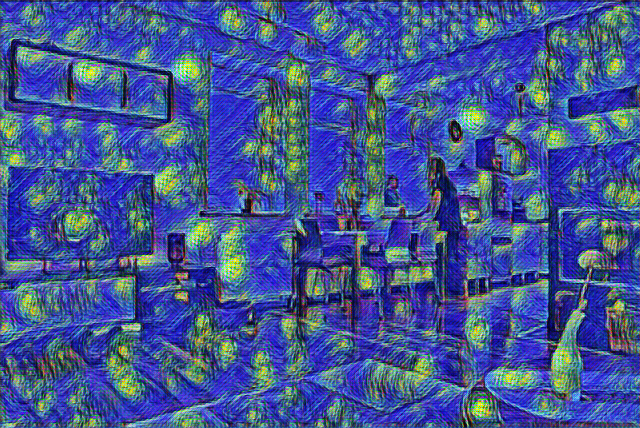

In [ ]:
img

In [ ]:
# if you just want to save the model state dict without other auxiliary info
checkpoint = torch.load(MODEL_DATA, map_location=torch.device('cpu'))
torch.save(checkpoint['model_state_dict'], 'model1.pt')